In [1]:
from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import logging
from optparse import OptionParser
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt


from scipy.sparse.linalg import svds
import utils

from string import punctuation
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
import nltk


In [2]:
categories = ['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

In [3]:
print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

7882 documents
8 categories


In [4]:
# stopping word

stop_words_skt = text.ENGLISH_STOP_WORDS

nltk.download('stopwords' )
stop_words_en = stopwords.words('english')

combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shuangyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
vectorizer = TfidfVectorizer(min_df=3, stop_words=combined_stopwords) 
X = vectorizer.fit_transform(dataset.data) # TF 

tfidf_transformer = TfidfTransformer()
X_tfidf  = tfidf_transformer.fit_transform(X)#TFIDF


## Problem 1

In [6]:

print('The size of TF/TFIDF: ',X_tfidf.shape)


The size of TF/TFIDF:  (7882, 27743)


In [7]:
km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1)
print("Clustering sparse data with :\n  %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with :
  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
done in 10.282s


In [8]:
labels = dataset.target

labels = (labels >3)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))

Homogeneity: 0.252
Completeness: 0.334
V-measure: 0.287
Adjusted Rand-Index: 0.179


Confusion matrix, without normalization
[[3899    4]
 [2269 1710]]


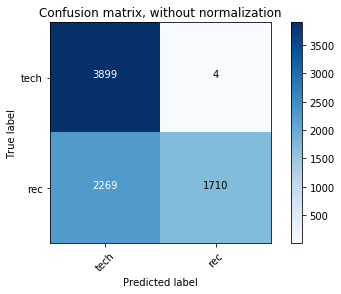

In [9]:
cnf_matrix = metrics.confusion_matrix(labels, km.labels_)
utils.plot_confusion_matrix(cnf_matrix, classes=['tech','rec'],
                      title='Confusion matrix, without normalization')

## Problem 3
-----------
### 1)


In [10]:
SVD = TruncatedSVD(n_components=1000)
X_LSI = SVD.fit_transform(X_tfidf)

Text(0,0.5,'variance')

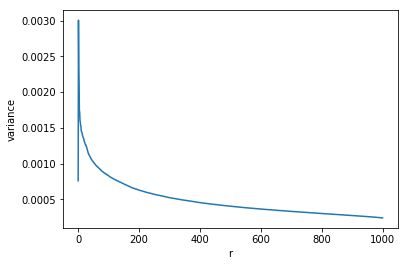

In [11]:
var = SVD.explained_variance_

plt.plot(var)
plt.xlabel('r')
plt.ylabel('variance')
# plt.savefig("plots/singular_values_part3.png", format='png')

### 2) LSI

In [41]:
scores_LSI = []
for r in range(1,50):
    X_truncated = X_LSI[:,:r]
#     print(X_truncated.shape)
    km_truncated = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1)
#     t0 = time()
    km_truncated.fit(X_truncated)
#     print("done in %0.3fs" % (time() - t0))
    labels = dataset.target
    labels = (labels >3)
    scores_LSI.append(utils.cluster_score(labels,km_truncated.labels_))

Text(0,0.5,'homogeneity')

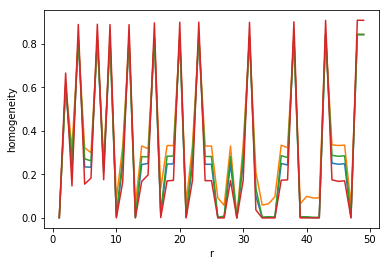

In [42]:
plt.plot(range(1,50),scores_LSI)
plt.xlabel('r')
plt.ylabel('homogeneity')

### 2) NMF

In [44]:
nmf = NMF(n_components=50, init='random', random_state=0)
X_NMF = nmf.fit_transform(X_tfidf)

In [45]:
scores_NMF = []
for r in range(1,50):
    X_truncated = X_NMF[:,:r]
    km_truncated = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1)
#     t0 = time()
    km_truncated.fit(X_truncated)
#     print("done in %0.3fs" % (time() - t0))
    labels = dataset.target
    labels = (labels >3)
    scores_NMF.append(utils.cluster_score(labels,km_truncated.labels_))

Text(0,0.5,'homogeneity')

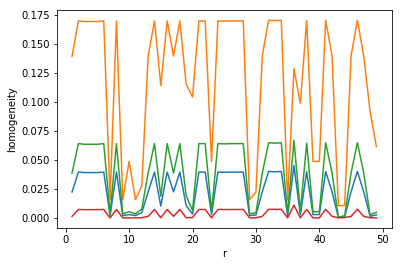

In [46]:
plt.plot(range(1,50),scores_NMF)
plt.xlabel('r')
plt.ylabel('homogeneity')

Text(0.5,0,'r')

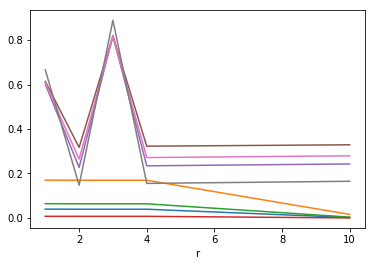

In [47]:
rs = [1,2,3,4,10]#,50,100,300]
scores_NMF = np.array(scores_NMF)
scores_LSI = np.array(scores_LSI)

scores_NMF_ = scores_NMF[rs[:]]
scores_LSI_ = scores_LSI[rs[:]]

plt.plot(rs,scores_NMF_)
plt.plot(rs,scores_LSI_)
plt.xlabel('r')
# plt.ylabel('homogeneity')

